# 01_explore — load, validate, sanity check

## Bootstrap (env & autoreload)

In [2]:
# Bootstrap: set repo root, show env, & auto-reload src/ code
import os, pathlib, sys, pandas as pd

# Ensure CWD is the repo root (parent of notebooks/)
if pathlib.Path().resolve().name == "notebooks":
    os.chdir("..")
print("CWD:", os.getcwd())
print("Python:", sys.version.split()[0], "| pandas:", pd.__version__)

# Auto-reload edited modules in src/ without full kernel restarts
%load_ext autoreload
%autoreload 2

CWD: /Users/abdulrahmanaboluhom/Documents/GitHub/Projects/indepth-driving-data-analysis
Python: 3.9.6 | pandas: 2.3.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [3]:
from pathlib import Path
from src.ingest import load_journey_event_with_config
from src.validate import validate_journey_event

## Config

### Sample data config

In [4]:
CFG = {
    "sheet_name": "Journey_Event_Sample",
    "header": "auto",
    "usecols": "B:BC",
    "nrows": 400,  # remove or set to None when loading full data
    "date_cols": ["RTC Date Time","GPS Date Time","Event Time Stamp"],
    "dayfirst": True,
    "keep_cols": [
        "Policy Number","Voucher ID","Journey ID",
        "Event Time Stamp","GPS Date Time",
        "Latitude","Longitude",
        "Event Type","Horizontal Speed","Road Speed Limit",
        "Accumulated Trip Distance","Accumulated Trip Idle Time","Accumulated Trip Run Time",
    ],
    "validate": True,  # run P-T-R on the keep set
}
file = "data/raw/driving_sample.xlsx"

### Full data config

In [5]:
CFG_FULL = {
    "sheet_name": "Journey Event",   # exact name in Excel
    "header": "auto",
    "usecols": "B:BC",               # skip blank col A if still there
    "date_cols": ["RTC Date Time","GPS Date Time","Event Time Stamp"],
    "dayfirst": True,
    "keep_cols": [
        "Policy Number","Voucher ID","Journey ID",
        "Event Time Stamp","GPS Date Time",
        "Latitude","Longitude",
        "Event Type","Horizontal Speed","Road Speed Limit",
        "Accumulated Trip Distance","Accumulated Trip Idle Time","Accumulated Trip Run Time",
    ],
    "validate": True
}

file_full = "data/raw/TMT Data Full.xlsx"

## Load (config-driven)

### Sample Data load

In [6]:
df_keep = load_journey_event_with_config(
    xlsx_path=file,
    cfg=CFG,
    write_interim=Path("data/interim/journey_event_sample_keep.parquet")
)

### Full Data load

In [7]:
df_keep_full = load_journey_event_with_config(
    xlsx_path=file_full,
    cfg=CFG_FULL,
    write_interim=Path("data/interim/journey_event_keep_full.parquet")
)

print("Rows:", len(df_keep_full))
print("Date range:", df_keep_full["GPS Date Time"].min(), "→", df_keep_full["GPS Date Time"].max())
print("Columns:", df_keep_full.columns.tolist())

Rows: 23405
Date range: 2024-11-28 20:17:33 → 2025-07-28 14:54:08
Columns: ['Policy Number', 'Voucher ID', 'Journey ID', 'Event Time Stamp', 'GPS Date Time', 'Latitude', 'Longitude', 'Event Type', 'Horizontal Speed', 'Road Speed Limit', 'Accumulated Trip Distance', 'Accumulated Trip Idle Time', 'Accumulated Trip Run Time']


## Sanity & Validation

In [8]:
print("shape:", df_keep.shape)
print("columns:", list(df_keep.columns)[:8], "…")
print(df_keep[["Event Time Stamp","Latitude","Longitude"]].dtypes)
from src.validate import validate_journey_event
validate_journey_event(df_keep)
print("✅ schema ok")

shape: (384, 13)
columns: ['Policy Number', 'Voucher ID', 'Journey ID', 'Event Time Stamp', 'GPS Date Time', 'Latitude', 'Longitude', 'Event Type'] …
Event Time Stamp    datetime64[ns]
Latitude                   float64
Longitude                  float64
dtype: object
✅ schema ok


## Exploration

### Sample Data Exploration

In [9]:
# 1) Make a copy of your CFG but turn validation off and drop keep_cols
CFG2 = {**CFG}
CFG2.pop("keep_cols", None)
CFG2["validate"] = False

# 2) Load full columns (no write)
df_full = load_journey_event_with_config(
    xlsx_path=file,
    cfg=CFG2,
    write_interim=None
)

# 3) Probe the columns you want to document
probe = ["Country","City","Road Speed Limit","Event Type ID","Delta Trip Distance"]
present = [c for c in probe if c in df_full.columns]
df_full[present].dtypes, df_full[present].nunique(), df_full[present].head(3)

(Country                object
 City                   object
 Road Speed Limit        int64
 Event Type ID           int64
 Delta Trip Distance     int64
 dtype: object,
 Country                 1
 City                    8
 Road Speed Limit        6
 Event Type ID           3
 Delta Trip Distance    18
 dtype: int64,
   Country      City  Road Speed Limit  Event Type ID  Delta Trip Distance
 0     GBR  BRADFORD                32              1                    0
 1     GBR  BRADFORD                32              3                    0
 2     GBR  BRADFORD                32              3                    0)

In [10]:
CFG = {
    "sheet_name": "Journey_Event_Sample",
    "header": "auto",
    "usecols": "B:BC",
    "nrows": 400,  # keep for speed now; remove later for full run
    "date_cols": ["RTC Date Time","GPS Date Time","Event Time Stamp"],
    "dayfirst": True,
    "keep_cols": [
        "Policy Number","Voucher ID","Journey ID",
        "Event Time Stamp","GPS Date Time",
        "Latitude","Longitude",
        "Event Type","Horizontal Speed","Road Speed Limit",
        "Accumulated Trip Distance","Accumulated Trip Idle Time","Accumulated Trip Run Time",
    ],
    "validate": True,
}

In [11]:
df_keep = load_journey_event_with_config(
    xlsx_path=file,
    cfg=CFG,
    write_interim=Path("data/interim/journey_event_sample_keep.parquet")
)

print("shape:", df_keep.shape)
print("cols:", list(df_keep.columns))
from src.validate import validate_journey_event
validate_journey_event(df_keep)
print("✅ schema ok")

shape: (384, 13)
cols: ['Policy Number', 'Voucher ID', 'Journey ID', 'Event Time Stamp', 'GPS Date Time', 'Latitude', 'Longitude', 'Event Type', 'Horizontal Speed', 'Road Speed Limit', 'Accumulated Trip Distance', 'Accumulated Trip Idle Time', 'Accumulated Trip Run Time']
✅ schema ok


Chosen Journey ID: 230797620241129093202


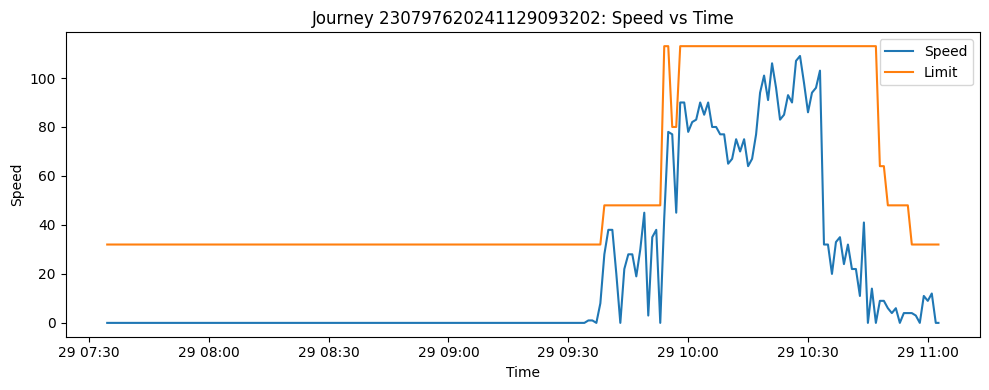

In [12]:
# pick a journey with enough points
jid = df_keep["Journey ID"].value_counts().index[0]
print("Chosen Journey ID:", jid)

# pick columns safely and build a single time axis
plot_cols = ["GPS Date Time","Event Time Stamp","Horizontal Speed","Road Speed Limit"]
present = [c for c in plot_cols if c in df_keep.columns]

subset = (df_keep[df_keep["Journey ID"] == jid]
          .sort_values(["GPS Date Time","Event Time Stamp"], ascending=True))[present].copy()
subset["when"] = subset["GPS Date Time"].fillna(subset["Event Time Stamp"])

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(subset["when"], subset["Horizontal Speed"], label="Speed")
if "Road Speed Limit" in subset.columns:
    plt.plot(subset["when"], subset["Road Speed Limit"], label="Limit")
plt.title(f"Journey {jid}: Speed vs Time")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Derive a single reliable timestamp column
# Prefer GPS time; if it's missing, use device event time.
df_keep = df_keep.copy()
df_keep["when"] = df_keep["GPS Date Time"].fillna(df_keep["Event Time Stamp"])

# Quick sanity: make sure it's datetime and we have data
assert str(df_keep["when"].dtype).startswith("datetime64"), "when is not datetime"
print("Non-null 'when' ratio:", df_keep["when"].notna().mean())
df_keep[["GPS Date Time","Event Time Stamp","when"]].head(3)

Non-null 'when' ratio: 1.0


,GPS Date Time,Event Time Stamp,when
0,2024-11-28 20:17:33,2024-11-28 20:34:58,2024-11-28 20:17:33
1,2024-11-28 20:35:58,2024-11-28 20:35:58,2024-11-28 20:35:58
2,2024-11-28 20:36:58,2024-11-28 20:36:58,2024-11-28 20:36:58


In [14]:
print("First event:", df_keep["when"].min())
print("Last event:", df_keep["when"].max())

# Extract hour (0..23) from 'when'
hours = df_keep["when"].dt.hour

# Count events per hour (0..23), fill missing hours with 0 for a clean plot
hour_counts = hours.value_counts().reindex(range(24), fill_value=0).sort_index()
hour_counts.head(), hour_counts.sum()


First event: 2024-11-28 20:17:33
Last event: 2024-11-30 21:43:51


(when
 0    35
 1     0
 2     0
 3     0
 4     0
 Name: count, dtype: int64,
 np.int64(384))

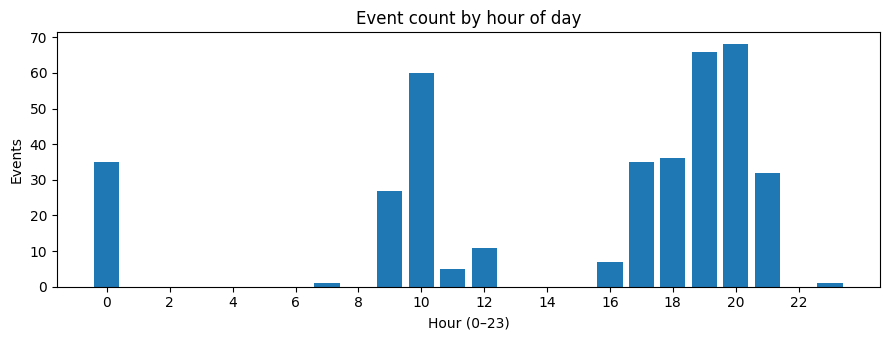

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,3.5))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Event count by hour of day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Events")
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.show()

In [16]:
print("First event:", df_keep["when"].min())
print("Last event:", df_keep["when"].max())

# Monday=0 ... Sunday=6
dow = df_keep["when"].dt.dayofweek
dow_counts = dow.value_counts().reindex(range(7), fill_value=0).sort_index()

# Friendly labels
labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
dow_counts.index = labels

dow_counts

First event: 2024-11-28 20:17:33
Last event: 2024-11-30 21:43:51


Mon      0
Tue      0
Wed      0
Thu     57
Fri    192
Sat    135
Sun      0
Name: count, dtype: int64

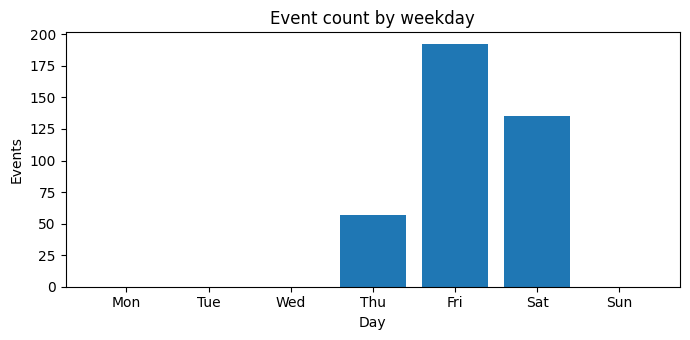

In [17]:
plt.figure(figsize=(7,3.5))
plt.bar(dow_counts.index, dow_counts.values)
plt.title("Event count by weekday")
plt.xlabel("Day")
plt.ylabel("Events")
plt.tight_layout()
plt.show()

### Full Data Explorations

In [18]:
# Create a single timestamp we trust for analysis
df_keep_full = df_keep_full.copy()
df_keep_full["when"] = df_keep_full["GPS Date Time"].fillna(df_keep_full["Event Time Stamp"])

# Quick sanity (fail fast if parsing drifted)
assert str(df_keep_full["when"].dtype).startswith("datetime64"), "when is not datetime"
print("Coverage:", df_keep_full["when"].min(), "→", df_keep_full["when"].max())

Coverage: 2024-11-28 20:17:33 → 2025-07-28 14:54:08


when
2024-11     437
2024-12    2857
2025-01    2307
2025-02    1675
2025-03    2698
2025-04    1940
2025-05    3268
2025-06    3689
2025-07    4534
Freq: M, Name: count, dtype: int64


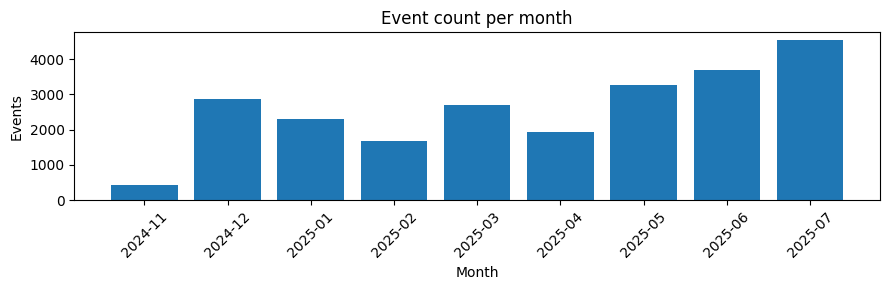

In [19]:
# Count events per calendar month (just to understand coverage)
monthly = (df_keep_full["when"]
           .dt.to_period("M")
           .value_counts()
           .sort_index())

# Show counts and a quick bar chart
print(monthly)

import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
plt.bar(monthly.index.astype(str), monthly.values)
plt.title("Event count per month")
plt.xlabel("Month")
plt.ylabel("Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

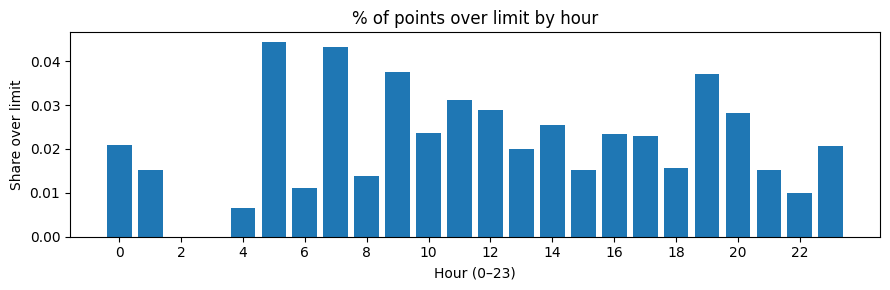

Counts per hour (for context):
when
0      144
1       66
2      103
3       66
4      154
5      203
6      910
7      648
8      503
9      719
10    1055
11     832
12    1105
13    1348
14    1617
15    1908
16    2530
17    2234
18    1735
19    2022
20    2025
21     928
22     405
23     145


In [20]:
# Build a clean set for speed/limit comparisons
cols = ["when","Horizontal Speed","Road Speed Limit"]
valid = df_keep_full[cols].dropna()
valid = valid[valid["Road Speed Limit"] > 0]  # avoid weird zeros

# Flag points over the posted limit
valid = valid.copy()
valid["over"] = valid["Horizontal Speed"] > valid["Road Speed Limit"]

# Compute over-limit RATE by hour of day
hour_idx = valid["when"].dt.hour
rate_by_hour = (valid.groupby(hour_idx)["over"]
                .mean()
                .reindex(range(24), fill_value=0))

# Also keep counts so low-sample hours are obvious
n_by_hour = (valid.groupby(hour_idx)["over"]
             .size()
             .reindex(range(24), fill_value=0))

# Plot the rate (0..1); underneath you can print counts
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
plt.bar(rate_by_hour.index, rate_by_hour.values)
plt.title("% of points over limit by hour")
plt.xlabel("Hour (0–23)")
plt.ylabel("Share over limit")
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.show()

print("Counts per hour (for context):")
print(n_by_hour.to_string())

In [21]:
# Prepare per-event "run seconds" using the cumulative field
df_rt = df_keep_full[["Journey ID","when","Accumulated Trip Run Time"]].dropna().copy()

# Sort within journeys and compute diffs (seconds since previous event)
df_rt = df_rt.sort_values(["Journey ID","when"])
df_rt["run_sec_delta"] = df_rt.groupby("Journey ID")["Accumulated Trip Run Time"].diff()

# Clean up: drop non-positive or absurdly large deltas (device hiccups)
df_rt = df_rt[(df_rt["run_sec_delta"] > 0) & (df_rt["run_sec_delta"] < 3600)]

# Night window: 22:00–04:00 (wraps midnight)
hr = df_rt["when"].dt.hour
night_mask = (hr >= 22) | (hr < 4)

night_hours = df_rt.loc[night_mask, "run_sec_delta"].sum() / 3600.0
total_hours = df_rt["run_sec_delta"].sum() / 3600.0
print(f"Estimated night driving hours (22:00–04:00): {night_hours:.2f} h")
print(f"Estimated total driving hours in coverage: {total_hours:.2f} h")
print(f"Night share: {night_hours/total_hours:.1%}")

Estimated night driving hours (22:00–04:00): 13.62 h
Estimated total driving hours in coverage: 354.09 h
Night share: 3.8%


### Calculating harsh Acceleration & Decelration

In [22]:
CFG_acc = {**CFG}
CFG_acc["keep_cols"] = CFG["keep_cols"] + [
    "Delta Accelerations 1","Delta Accelerations 2","Delta Accelerations 3",
    "Delta Accelerations 4","Delta Accelerations 5","Delta Accelerations 6",
    "Delta Accelerations 7","Delta Accelerations 8","Delta Accelerations 9",
    "Delta Accelerations 10",
    "Delta Decelerations 1","Delta Decelerations 2","Delta Decelerations 3",
    "Delta Decelerations 4","Delta Decelerations 5","Delta Decelerations 6",
    "Delta Decelerations 7","Delta Decelerations 8","Delta Decelerations 9",
    "Delta Decelerations 10"
]
CFG_acc["validate"] = False  # skip schema temporarily

df_accel = load_journey_event_with_config(
    xlsx_path=file,
    cfg=CFG_acc,
    write_interim=None
)
print("Shape with accel/decel:", df_accel.shape)

Shape with accel/decel: (384, 33)


In [23]:
accel_cols = [c for c in df_accel.columns if "Delta Accelerations" in c]
decel_cols = [c for c in df_accel.columns if "Delta Decelerations" in c]

df_accel[accel_cols + decel_cols].describe()

,Delta Accelerations 1,Delta Accelerations 2,Delta Accelerations 3,Delta Accelerations 4,Delta Accelerations 5,Delta Accelerations 6,Delta Accelerations 7,Delta Accelerations 8,Delta Accelerations 9,Delta Accelerations 10,Delta Decelerations 1,Delta Decelerations 2,Delta Decelerations 3,Delta Decelerations 4,Delta Decelerations 5,Delta Decelerations 6,Delta Decelerations 7,Delta Decelerations 8,Delta Decelerations 9,Delta Decelerations 10
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.0,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.0,384.0,384.0
mean,2.640625,2.221354,1.005208,0.468750,0.276042,0.145833,0.052083,0.020833,0.002604,0.0,2.346354,0.802083,0.523438,0.375000,0.364583,0.174479,0.007812,0.0,0.0,0.0
std,7.797437,5.315180,2.334881,1.153522,0.805885,0.540364,0.284308,0.160233,0.051031,0.0,7.287268,1.748523,1.149173,0.858075,1.015491,0.615954,0.088157,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,60.000000,49.000000,18.000000,8.000000,6.000000,5.000000,3.000000,2.000000,1.000000,0.0,60.000000,13.000000,10.000000,6.000000,7.000000,4.000000,1.000000,0.0,0.0,0.0


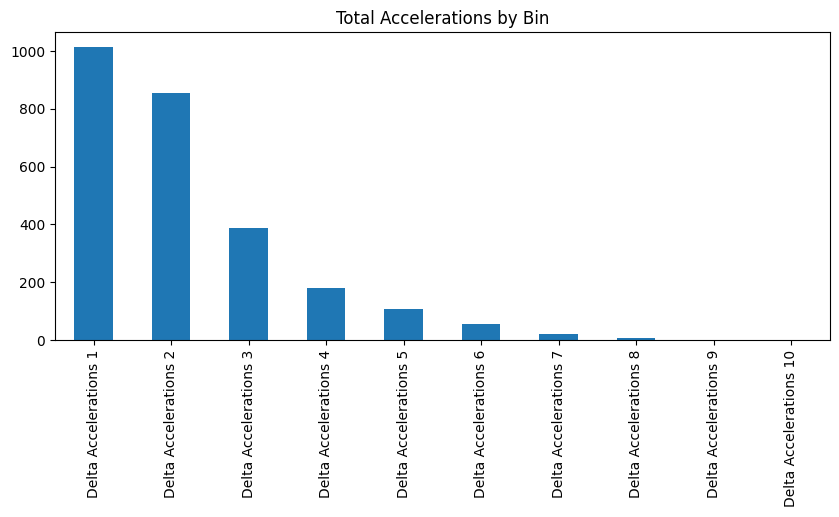

In [24]:
import matplotlib.pyplot as plt

df_accel[accel_cols].sum().plot(kind="bar", figsize=(10,4), title="Total Accelerations by Bin")
plt.show()

In [29]:
CFG_cols = {**CFG_FULL, "nrows": 0, "validate": False}
CFG_cols.pop("keep_cols", None)   # critical: see all columns
df_cols = load_journey_event_with_config(xlsx_path=file_full, cfg=CFG_cols, write_interim=None)

decel_cols = [c for c in df_cols.columns if "Delta Decelerations" in c]
print(len(decel_cols), "decel cols:", decel_cols)

10 decel cols: ['Delta Decelerations 1', 'Delta Decelerations 2', 'Delta Decelerations 3', 'Delta Decelerations 4', 'Delta Decelerations 5', 'Delta Decelerations 6', 'Delta Decelerations 7', 'Delta Decelerations 8', 'Delta Decelerations 9', 'Delta Decelerations 10']


In [30]:
CFG_brake = {**CFG_FULL, "validate": False}
CFG_brake["keep_cols"] = CFG_FULL["keep_cols"] + decel_cols

df_brake = load_journey_event_with_config(xlsx_path=file_full, cfg=CFG_brake, write_interim=None)
print("shape:", df_brake.shape)

shape: (23405, 23)


In [31]:
df_decel = df_brake[["Journey ID"] + decel_cols].copy()

Harsh braking share (bins ≥7): 0.40%


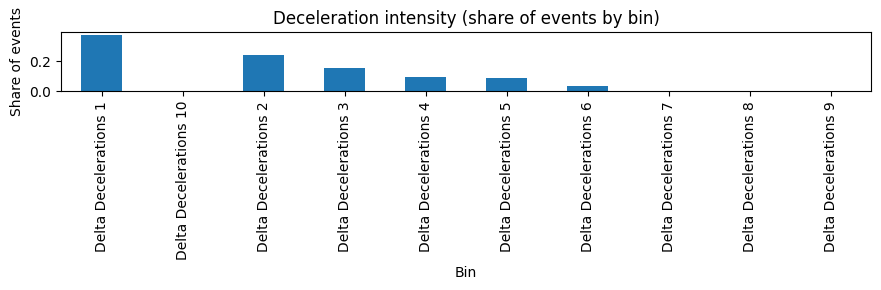

In [32]:
import pandas as pd, matplotlib.pyplot as plt

totals = df_brake[decel_cols].sum()
share = (totals / totals.sum()).sort_index()

harsh_bins = [c for c in decel_cols if c.split()[-1].isdigit() and int(c.split()[-1]) >= 7]
harsh_share = df_brake[harsh_bins].sum().sum() / totals.sum()
print(f"Harsh braking share (bins ≥7): {harsh_share:.2%}")

plt.figure(figsize=(9,3))
share.plot(kind="bar")
plt.title("Deceleration intensity (share of events by bin)")
plt.ylabel("Share of events")
plt.xlabel("Bin")
plt.tight_layout()
plt.show()

Manual harsh %: 0.4035990669085793


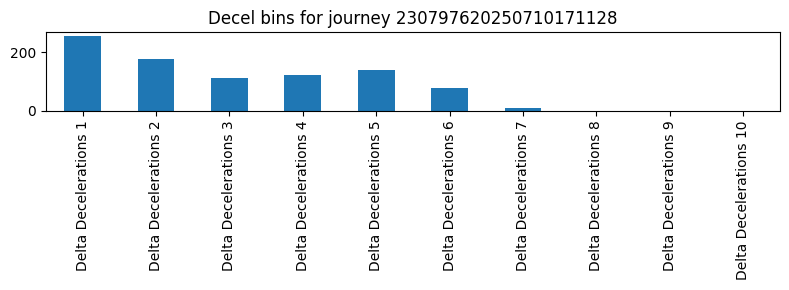

In [33]:
# A) Manual math
total = df_decel[decel_cols].to_numpy().sum()
harsh = df_decel[[f"Delta Decelerations {i}" for i in range(7,11)]].to_numpy().sum()
print("Manual harsh %:", 100 * harsh / total)

# B) One journey visual
jid = df_decel["Journey ID"].value_counts().index[0]
df_decel[df_decel["Journey ID"] == jid][decel_cols].sum().plot(kind="bar", figsize=(8,3),
                                                               title=f"Decel bins for journey {jid}")
plt.tight_layout(); plt.show()

### Compliance = speeding

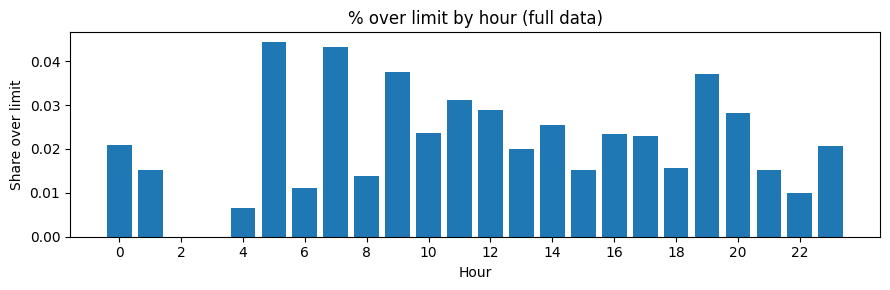

Counts per hour:
 when
0      144
1       66
2      103
3       66
4      154
5      203
6      910
7      648
8      503
9      719
10    1055
11     832
12    1105
13    1348
14    1617
15    1908
16    2530
17    2234
18    1735
19    2022
20    2025
21     928
22     405
23     145


In [34]:
# 1) ensure we’re on curated full set
df = df_keep_full.copy()
df["when"] = df["GPS Date Time"].fillna(df["Event Time Stamp"])

# 2) clean comparison rows
need = ["when","Horizontal Speed","Road Speed Limit"]
valid = df[need].dropna()
valid = valid[valid["Road Speed Limit"] > 0]

# 3) flag and aggregate
valid["over"] = valid["Horizontal Speed"] > valid["Road Speed Limit"]
rate_by_hour = (valid.groupby(valid["when"].dt.hour)["over"]
                .mean()
                .reindex(range(24), fill_value=0))
n_by_hour = (valid.groupby(valid["when"].dt.hour)["over"]
             .size()
             .reindex(range(24), fill_value=0))

# 4) plot
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
plt.bar(rate_by_hour.index, rate_by_hour.values)
plt.title("% over limit by hour (full data)")
plt.xlabel("Hour"); plt.ylabel("Share over limit")
plt.xticks(range(0,24,2)); plt.tight_layout(); plt.show()

print("Counts per hour:\n", n_by_hour.to_string())

In [35]:
df_keep["Journey ID"].nunique()

12

In [36]:
df_keep.groupby("Journey ID").size().describe()

count    12.000000
mean     32.000000
std      31.714637
min       2.000000
25%       9.750000
50%      16.000000
75%      45.500000
max      92.000000
dtype: float64

In [37]:
df_keep.groupby("Journey ID").size()

Journey ID
230797620241128203458    37
230797620241128211259    20
230797620241129093202    92
230797620241129122442    11
230797620241129182314    88
230797620241130001134    12
230797620241130002412    10
230797620241130003551     5
230797620241130004923     9
230797620241130165320    42
230797620241130194513    56
230797620241130214251     2
dtype: int64

In [38]:
df_keep["Journey ID"].nunique()

12

In [39]:
df = df_keep_full  # from Journey Event
df["Journey ID"].nunique(), len(df)

(1345, 23405)

# Dev helpers (Archive)

In [ ]:
from src.ingest import load_journey_event_with_config

CFG = {
    "sheet_name": "Journey_Event_Sample",
    "header": "auto",
    "usecols": "B:BC",
    "nrows": 400,  # sample for speed; remove later for full load
    "date_cols": ["RTC Date Time","GPS Date Time","Event Time Stamp"],
    "dayfirst": True,
    "keep_cols": [
        "Policy Number","Voucher ID","Journey ID",
        "Event Time Stamp","GPS Date Time",
        "Latitude","Longitude",
        "Event Type","Horizontal Speed","Road Speed Limit",
        "Accumulated Trip Distance","Accumulated Trip Idle Time","Accumulated Trip Run Time",
    ],
    "validate": True,  # run P‑T‑R on the keep set
}

file = "data/raw/driving_sample.xlsx"

df_keep = load_journey_event_with_config(
    xlsx_path=file,
    cfg=CFG,
    write_interim=Path("data/interim/journey_event_sample_keep.parquet")  # or None if you don’t want to write
)

df_keep.head(2), df_keep.shape

In [ ]:
import importlib, types

import src.ingest as ingest
importlib.reload(ingest)     # picks up latest file contents

print("Attributes on ingest:", [a for a in dir(ingest) if not a.startswith("_")])

In [ ]:
from src.ingest import load_journey_event

In [ ]:
# testing function
# import the loader
from src.ingest import load_journey_event

file = "data/raw/driving_sample.xlsx"
sheet = "Journey_Event_Sample"

df = load_journey_event(
    xlsx_path=file,
    sheet_name=sheet,
    header="auto",                      # or 0 if you want to force it
    usecols="B:BC",                     # skip blank col A
    nrows=400,                          # sample size for speed
    date_cols=["RTC Date Time","GPS Date Time","Event Time Stamp"],
    dayfirst=True
)

df.head(2), df.shape

In [ ]:
#Data path & sheet list (Code)

from pathlib import Path
DATA = Path("data/raw")
file = DATA / "driving_sample.xlsx"  # <-- change to actual filename
print("File exists:", file.exists())

xls = pd.ExcelFile(file)
xls.sheet_names  # check the exact messy sheet name here

In [ ]:
print("shape:", df.shape)
print("first 12 columns:", df.columns[:12].tolist())

# QUICK: are the three date columns even present?
date_cols = ["RTC Date Time", "GPS Date Time", "Event Time Stamp"]
present = [c for c in date_cols if c in df.columns]
missing = [c for c in date_cols if c not in df.columns]
print("date cols present:", present, "| missing:", missing)

# show dtypes of a few key columns
cols_probe = present + [c for c in ["Event Type","Latitude","Longitude","Horizontal Speed","Road Speed Limit"] if c in df.columns]
df[cols_probe].dtypes

In [ ]:
# column auditing

rows = []
for col in df.columns:
    s = df[col]
    rows.append({
        "column": col,
        "dtype": str(s.dtype),
        "null_pct": round(100 * (1 - s.notna().mean()), 2),
        "n_unique": int(s.nunique(dropna=True)),
    })
audit = pd.DataFrame(rows).sort_values(["dtype","column"]).reset_index(drop=True)
audit.head(15)

In [ ]:
probe = ["Event Type","Delta Trip Distance","Direction","Altitude","GPS Accuracy"]
[c for c in probe if c in df.columns], df[probe].head(2)